In [3]:
using PyPlot
import Delaunator as D
using PyCall
@pyimport matplotlib.animation as anim
@pyimport IPython.display as d

In [4]:
function plot_mapped_grid(R, n1, n2=n1)
    xy = Vector{Float64}[ R([ξ,η]) for ξ in (0:n1)./n1, η in (0:n2)./n2 ]
    x,y = first.(xy), last.(xy)
    plot(x, y, "k", x', y', "k", linewidth=1)
end

plot_mapped_grid (generic function with 2 methods)

In [5]:
A = 0.4
ybottom(x) = 64*A*x^3 * (1-x)^3
ytop(x) = 1 + A*x^3 * (6*x^2 - 15*x + 10) 

yderbottom(x) = 192*A*x^2 * (1-x)^3 - 192*A*x^3 * (1-x)^2
ydertop(x) = A * (30*x^4 - 60*x^3 + 30*x^2)

ydertop (generic function with 1 method)

In [6]:
function tfi_linear(ξη)

    # Boundaries
    left = [0, ytop(0)*ξη[2]]
    right = [1, ytop(1)*ξη[2]]
    bottom = [ξη[1], ybottom(ξη[1])]
    top = [ξη[1], ytop(ξη[1])]

    # Corners
    sw = [0, ybottom(0)] 
    nw = [0, ytop(0)]
    se = [1, ybottom(1)]
    ne = [1, ytop(1)]
    
    xy = (1-ξη[1]) * left + ξη[1] * right + (1 - ξη[2]) * bottom + ξη[2] * top - (1-ξη[1]) * (1-ξη[2]) * sw - (1-ξη[1]) * ξη[2] * nw - ξη[1] * (1-ξη[2]) * se - ξη[1] * ξη[2] * ne
    return xy
end

tfi_linear (generic function with 1 method)

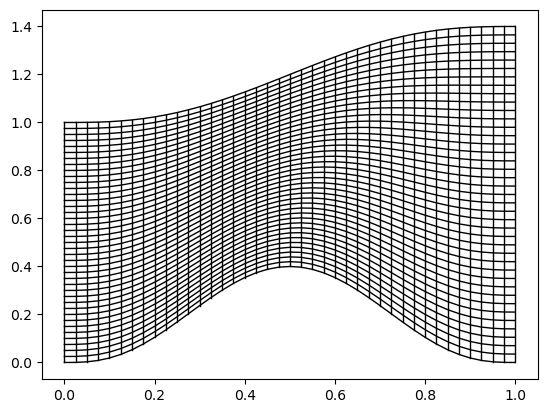

In [7]:
clf()
plot_mapped_grid(tfi_linear, 40)
gcf()

In [8]:
H0(η) = 2*η^3 - 3η^2 + 1
H1(η) = 3*η^2 - 2*η^3
H0_tilde(η) = η^3 - 2*η^2 + η
H1_tilde(η) = η^3 - η^2

H1_tilde (generic function with 1 method)

In [9]:
function tfi_orthogonal(ξη)
    T = 0.5

    x = 1*H1(ξη[1]) + T*H0_tilde(ξη[1]) + T*H1_tilde(ξη[1])
    
    # Boundaries
    bottom = [x, ybottom(x)]
    top = [x, ytop(x)]

    # Normal vectors 
    dx = 1
    dybottom = yderbottom(x)
    dytop = ydertop(x)
    nbottom = (1/sqrt(dybottom^2+dx^2)) .* [-dybottom, dx]
    ntop = (1/sqrt(dytop^2+dx^2)) .* [-dytop, dx]

    xy = @. bottom*H0(ξη[2]) + top*H1(ξη[2]) + T * (nbottom*H0_tilde(ξη[2]) + ntop*H1_tilde(ξη[2]))
    return xy
end

tfi_orthogonal (generic function with 1 method)

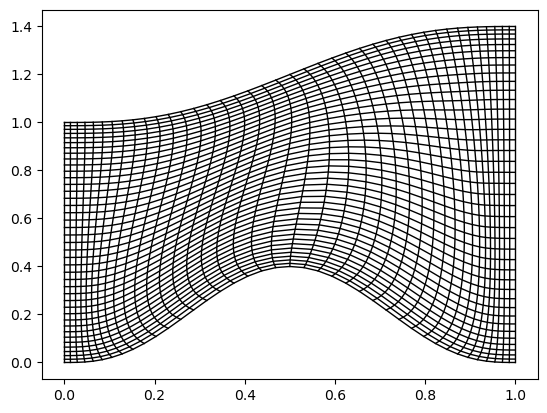

In [10]:
clf()
plot_mapped_grid(tfi_orthogonal, 40)
gcf()

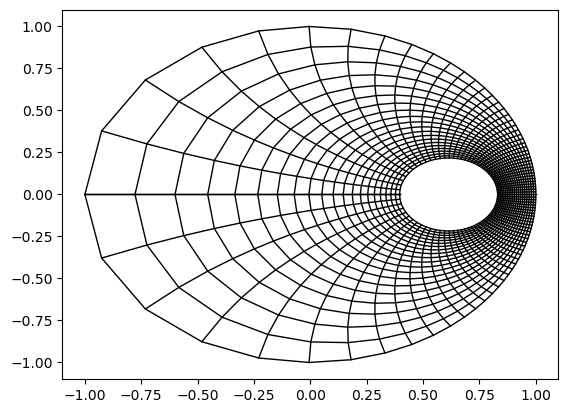

In [11]:
function R(ξη)
    z = ξη[1] + 2*pi*ξη[2] * 1im 
    w = (2*exp(z) - 3) / (3*exp(z) - 2)
    xy = [real(w), imag(w)]
    return xy
end

clf()
plot_mapped_grid(R, 20, 80)
gcf()

In [12]:
"""
    t = delaunay(p)

Delaunay triangulation `t` of N x 2 node array `p`.
"""
delaunay(p) = collect(reinterpret(reshape, Int32, 
        D.triangulate(D.PointsFromMatrix(p')).triangles)')

"""
inside = inpolygon(p, pv)

Determine if each point in the N x 2 node array `p` is inside the polygon
described by the NE x 2 node array `pv`.
"""
function inpolygon(p, pv)
    if ndims(p) == 2 && size(p,2) == 2
        return [ inpolygon(p[ip,:], pv) for ip = 1:size(p,1) ]
    end
    cn = 0
    for i = 1:size(pv,1) - 1
        if pv[i,2] <= p[2] && pv[i+1,2] > p[2] ||
            pv[i,2] > p[2] && pv[i+1,2] <= p[2]
            vt = (p[2] - pv[i,2]) / (pv[i+1,2] - pv[i,2])
            if p[1] < pv[i,1] + vt * (pv[i+1,1] - pv[i,1])
                cn += 1
            end
        end
    end
    return cn % 2 == 1
end
"""
    edges, boundary_indices, emap = all_edges(t)

Find all unique edges in the triangulation `t` (ne x 2 array)
Second output is indices to the boundary edges.
Third output emap (nt x 3 array) is a mapping from local triangle edges
to the global edge list, i.e., emap[it,k] is the global edge number
for local edge k (1,2,3) in triangle it.
"""
function all_edges(t)
    etag = vcat(t[:,[1,2]], t[:,[2,3]], t[:,[3,1]])
    etag = hcat(sort(etag, dims=2), 1:3*size(t,1))
    etag = sortslices(etag, dims=1)
    dup = all(etag[2:end,1:2] - etag[1:end-1,1:2] .== 0, dims=2)[:]
    keep = .![false;dup]
    edges = etag[keep,1:2]
    emap = cumsum(keep)
    invpermute!(emap, etag[:,3])
    emap = reshape(emap,:,3)
    dup = [dup;false]
    dup = dup[keep]
    bndix = findall(.!dup)
    return edges, bndix, emap
end
"""
    tplot(p, t, u=nothing)

If `u` == nothing: Plot triangular mesh with nodes `p` and triangles `t`.
If `u` == solution vector: Plot filled contour color plot of solution `u`.
"""
function tplot(p, t, u=nothing)
    clf()
    axis("equal")
    if u == nothing
        tripcolor(p[:,1], p[:,2], Array(t .- 1), 0*t[:,1],
                  cmap="Set3", edgecolors="k", linewidth=1)
    else
        tricontourf(p[:,1], p[:,2], Array(t .- 1), u[:], 20)
    end
    draw()
end
"""
    e = boundary_nodes(t)

Find all boundary nodes in the triangulation `t`.
"""
function boundary_nodes(t)
    edges, boundary_indices, _ = all_edges(t)
    return unique(edges[boundary_indices,:][:])
end

boundary_nodes

In [13]:
function area(p, triangle)
    points = [p[triangle[1],:] p[triangle[2],:] p[triangle[3],:]]
    x, y = points[1,:], points[2,:]
    return 1/2 * abs(x[1]*(y[2]-y[3]) + x[2]*(y[3]-y[1]) + x[3]*(y[1]-y[2]))
end

function findlargest(p, t)
    maxarea = 0
    maxindex = 0
    for i = 1:size(t, 1)
        if area(p, t[i, :]) > maxarea
            maxarea = area(p, t[i, :])
            maxindex = i
        end
    end
    return maxarea, maxindex
end

function circumcenter(A, B, C)
    B = B - A
    C = C - A
    D = 2 * (B[1]*C[2] - B[2]*C[1])
    Ux = 1 / D * (C[2] * (B[1]^2 + B[2]^2) - B[2] * (C[1]^2 + C[2]^2))
    Uy = 1 / D * (B[1] * (C[1]^2 + C[2]^2) - C[1] * (B[1]^2 + B[2]^2))
    U = [Ux + A[1], Uy + A[2]]
    return U
end

function deletetriangles(p, pv, t)
    badtriangles = []
    for i = 1:size(t, 1)
        triangle = t[i, :]
        midpoint = 1/3 * (p[triangle[1], :] + p[triangle[2],:] + p[triangle[3],:])
        if inpolygon(midpoint, pv) == false || area(p, triangle) < 10^-12
            badtriangles = push!(badtriangles, i)
        end
    end
    return t[begin:end .∉ [badtriangles],:]
end

deletetriangles (generic function with 1 method)

In [14]:
@pyimport IPython.display as d
"""
    mkanim(x, allu)

Utility for animating PDE solutions in a Jupyter notebook.
"""
function mkanim(allp, allt)
    animation = pyimport("matplotlib.animation");
    fig, ax = subplots(figsize=(6,4.5))
    function update(frame)
        ax.tripcolor(allp[frame+1][:,1], allp[frame+1][:,2], Array(allt[frame+1] .- 1), 0*allt[frame+1][:,1],
                    cmap="Set3", edgecolors="k", linewidth=1)
        ax.plot(allp[frame+1][:,1], allp[frame+1][:,2], ".", color="k", markersize=18), axis("equal")
    end
    ani = animation.FuncAnimation(fig, update, frames=length(allt), interval=200)
    close(ani._fig)
    d.HTML(ani.to_jshtml())
end

mkanim

In [31]:
@pyimport IPython.display as d
function pmesh(pv, hmax, nref, savesolutions = false)
    N = size(pv, 1) - 1
    p = pv[1:end-1,:]
    # b)
    for i = 1:N
        segmentlength = sqrt((p[i,1] - p[i+1,1])^2 + (p[i,2] - p[i+1,2])^2)
        numnodes = trunc(Int32, ceil(segmentlength/hmax)) + 1
        if numnodes > 2
            extranodes = [LinRange(pv[i,1], pv[i+1,1], numnodes), LinRange(pv[i,2], pv[i+1,2], numnodes)]
            extranodes = [extranodes[1][begin+1:end-1] extranodes[2][begin+1:end-1]]
            p = vcat(p, extranodes)
        end
    end
    
    # c)
    t = delaunay(p)
    
    # d)
    t = deletetriangles(p, pv, t)
    if savesolutions
        allp = [copy(p)]
        allt = [copy(t)]
    end


    # e)-g)
    maxarea, maxindex = findlargest(p, t)
    while maxarea > hmax^2 /2
        indx = t[maxindex,:]
        circ = circumcenter(p[indx[1],:], p[indx[2],:], p[indx[3],:])
        p = vcat(p, reshape(circ,(1,2)))
        if savesolutions
            push!(allp, copy(p))
            push!(allt, copy(t))
        end
    
        t = delaunay(p)
        t = deletetriangles(p, pv, t)
        maxarea, maxindex = findlargest(p, t)
        if savesolutions
            push!(allp, copy(p))
            push!(allt, copy(t))
        end
    end

    # h)
    for i = 1:nref
        edges, bndix, emap = all_edges(t)
        centerpoints = zeros(size(edges, 1), 2)
        for j = 1:size(edges, 1)
            centerpoints[j,:] = (p[edges[j,1],:] + p[edges[j,2],:])/2
        end
        p = vcat(p, centerpoints)
        t = delaunay(p)
        t = deletetriangles(p, pv, t)
        if savesolutions
            push!(allp, copy(p))
            push!(allt, copy(t))    
        end
    end
    
    e = boundary_nodes(t)
    if savesolutions
        return p, t, e, allp, allt
    else
        return p, t, e
    end
end

pv = [0 0; 1 0; .5 .5; 1 1; 0 1; 0 0]
#pv = [0 0; .25 .5; 0 1; .5 .75; 1 1; .75 .5; 1 0; .5 .25; 0 0]

p, t, e, allp, allt = pmesh(pv, 0.4, 0, true)
#p, t, e = pmesh(pv, 0.2, 1)
mkanim(allp, allt)

PyObject <IPython.core.display.HTML object>